# **Exploratory Data Analysis**

## **This Notebook**
In this notebook we will perfom Exploratory Data Analysis to
- Handle missing values
- Clean the image dataset by removing non-poster images
- Cluster movie genres into five thematic macro-groups
- Download posters

### **1.1 Import necessary libaries**

In [48]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import requests
import scipy.cluster.hierarchy as sch
import openai
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
from config_loader import load_config_value
openai_api_key = load_config_value("OPENAI_API_KEY")
omdb_key = load_config_value("OMDB_API_KEY")

### **1.2 Load the movie dataset**

In [6]:
df = pd.read_csv('filtered_movies.csv')

In [7]:
df.head()

,tconst,title,year,genre,director,actors,plot,country,awards,poster,rating,votes,type,metascore
0,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,9.0,10.0,movie,NaN
1,tt15908496,Dear Jackie,2021,Documentary,Henri Pardo,"Ronald Jones, Ivan Livingstone, Majiza Philips",Dear Jackie paints a picture of the Black comm...,Canada,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDIwYz...,7.5,16.0,movie,NaN
2,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,7.1,36.0,movie,NaN
3,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,7.7,79.0,movie,NaN
4,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,8.2,7.0,movie,NaN


In [8]:
# Drop the "Unnamed: 0" column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53634 entries, 0 to 53633
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tconst     53634 non-null  object 
 1   title      53634 non-null  object 
 2   year       53634 non-null  object 
 3   genre      52907 non-null  object 
 4   director   53229 non-null  object 
 5   actors     49859 non-null  object 
 6   plot       49756 non-null  object 
 7   country    53258 non-null  object 
 8   awards     38105 non-null  object 
 9   poster     48785 non-null  object 
 10  rating     50478 non-null  float64
 11  votes      30029 non-null  float64
 12  type       53634 non-null  object 
 13  metascore  23024 non-null  float64
dtypes: float64(3), object(11)
memory usage: 5.7+ MB


### **2. Handling missing values**

In [10]:
df.isnull().sum()

tconst           0
title            0
year             0
genre          727
director       405
actors        3775
plot          3878
country        376
awards       15529
poster        4849
rating        3156
votes        23605
type             0
metascore    30610
dtype: int64

#### **2.1 Approach**

- genre --> replace 'N/A' values using `title.basics.tsv` IMDB Dataset
- director --> replace 'N/A' values with 'Unknown'
- actors --> replace 'N/A' values with 'Unknown'
- plot --> Delate raws having plot = 'N/A'
- poster --> Delate raws having plot = 'N/A'
- country  --> replace 'N/A' values with 'Unknown'
- awards --> replace 'N/A' values with sentence '0 awards and 0 nominees'
- rating & votes --> replace 'N/A' values using `title.ratings.tsv` IMDB Dataset

In [12]:
## Load the IMDB datasets
imdb_dataset_path = '../IMDB_Dataset/'

# Load IMDb datasets
title_basics = pd.read_csv(imdb_dataset_path + 'title.basics.tsv', sep='\t', dtype=str, na_values=['\\N'])
title_ratings = pd.read_csv(imdb_dataset_path + 'title.ratings.tsv', sep='\t', dtype={'tconst': str, 'averageRating': float, 'numVotes': int}, na_values=['\\N'])


In [13]:
# Convert 'N/A' values to NaN for easier handling
df.replace('N/A', pd.NA, inplace=True)

# 1. Impute 'genre' using title.basics.tsv
df = df.merge(title_basics[['tconst', 'genres']], on='tconst', how='left')
df['genre'].fillna(df['genres'], inplace=True)
df.drop(columns=['genres'], inplace=True)

# 2. Impute 'director', 'actors' and 'country' with 'Unknown'
df['director'].fillna('Unknown', inplace=True)
df['actors'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)

# 3. Remove rows where 'plot' and 'poster' is missing
df.dropna(subset=['plot', 'poster'], inplace=True)

# 4. Replace missing 'awards' with default text
df['awards'].fillna('0 awards and 0 nominees', inplace=True)

# 5. Impute 'rating' and 'votes' using title.ratings.tsv
df = df.merge(title_ratings[['tconst', 'averageRating', 'numVotes']], on='tconst', how='left')
df['rating'].fillna(df['averageRating'], inplace=True)
df['votes'].fillna(df['numVotes'], inplace=True)
df.drop(columns=['averageRating', 'numVotes'], inplace=True)

/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_80743/344808975.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['genre'].fillna(df['genres'], inplace=True)
/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_80743/344808975.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [14]:
df.isnull().sum()

tconst           0
title            0
year             0
genre          216
director         0
actors           0
plot             0
country          0
awards           0
poster           0
rating           0
votes            0
type             0
metascore    28849
dtype: int64

Drop the remaining 216 missings

In [16]:
df.dropna(subset=['genre'], inplace=True)

In [17]:
df.drop('metascore', axis=1, inplace=True)

In [18]:
df.shape

(46535, 13)

### **3. Additional cleaning**

In [20]:
# Checking the content type
df.type.value_counts()

type
movie      46526
series         8
episode        1
Name: count, dtype: int64

In [21]:
# We only want to keep the 'movies'
# Remove rows from the DataFrame
df = df[df["type"] == "movie"]

# Display updated type counts to verify deletion
print(df["type"].value_counts())

type
movie    46526
Name: count, dtype: int64


### **4. Movie genre analysis**

In [23]:
# Checking the movie genres in the dataset
multigenre = df.genre.value_counts()

with open("multigenre.txt", "w") as file:
    file.write(multigenre.to_string())

In [52]:
# Split the 'genre' column into list of genres
df['genre_list'] = df['genre'].str.split(',\s*')

# One-Hot Encoding the “genre” Feature
mlb = MultiLabelBinarizer()
one_hot_genres = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
one_hot_genres.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_80743/3250552409.py:2: SyntaxWarning: invalid escape sequence '\s'
  df['genre_list'] = df['genre'].str.split(',\s*')


,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Text(0.5, 1.0, 'Distribution of Movie Genres by Count')

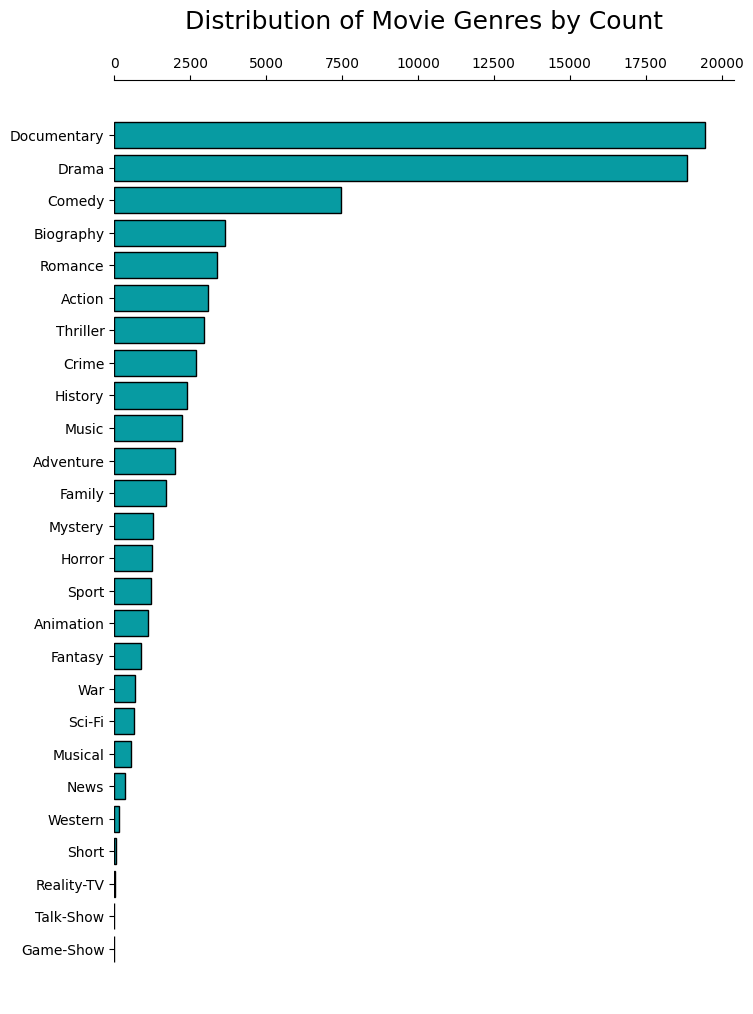

In [53]:
# genre distribution

# Sort genres by count in descending order
genre_count = one_hot_genres.sum().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 12))
ax.barh(genre_count.index, genre_count.values, color='#079BA2', edgecolor='black')
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()

# Labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Distribution of Movie Genres by Count',
             size=18,
             color='black',
             pad=20)

In [54]:
# count rows with more than one genre
multi_genre_images = (one_hot_genres.sum(axis=1) > 1).sum()

print(f"Number of movies with more than one genre: {multi_genre_images}")

Number of movies with more than one genre: 21122


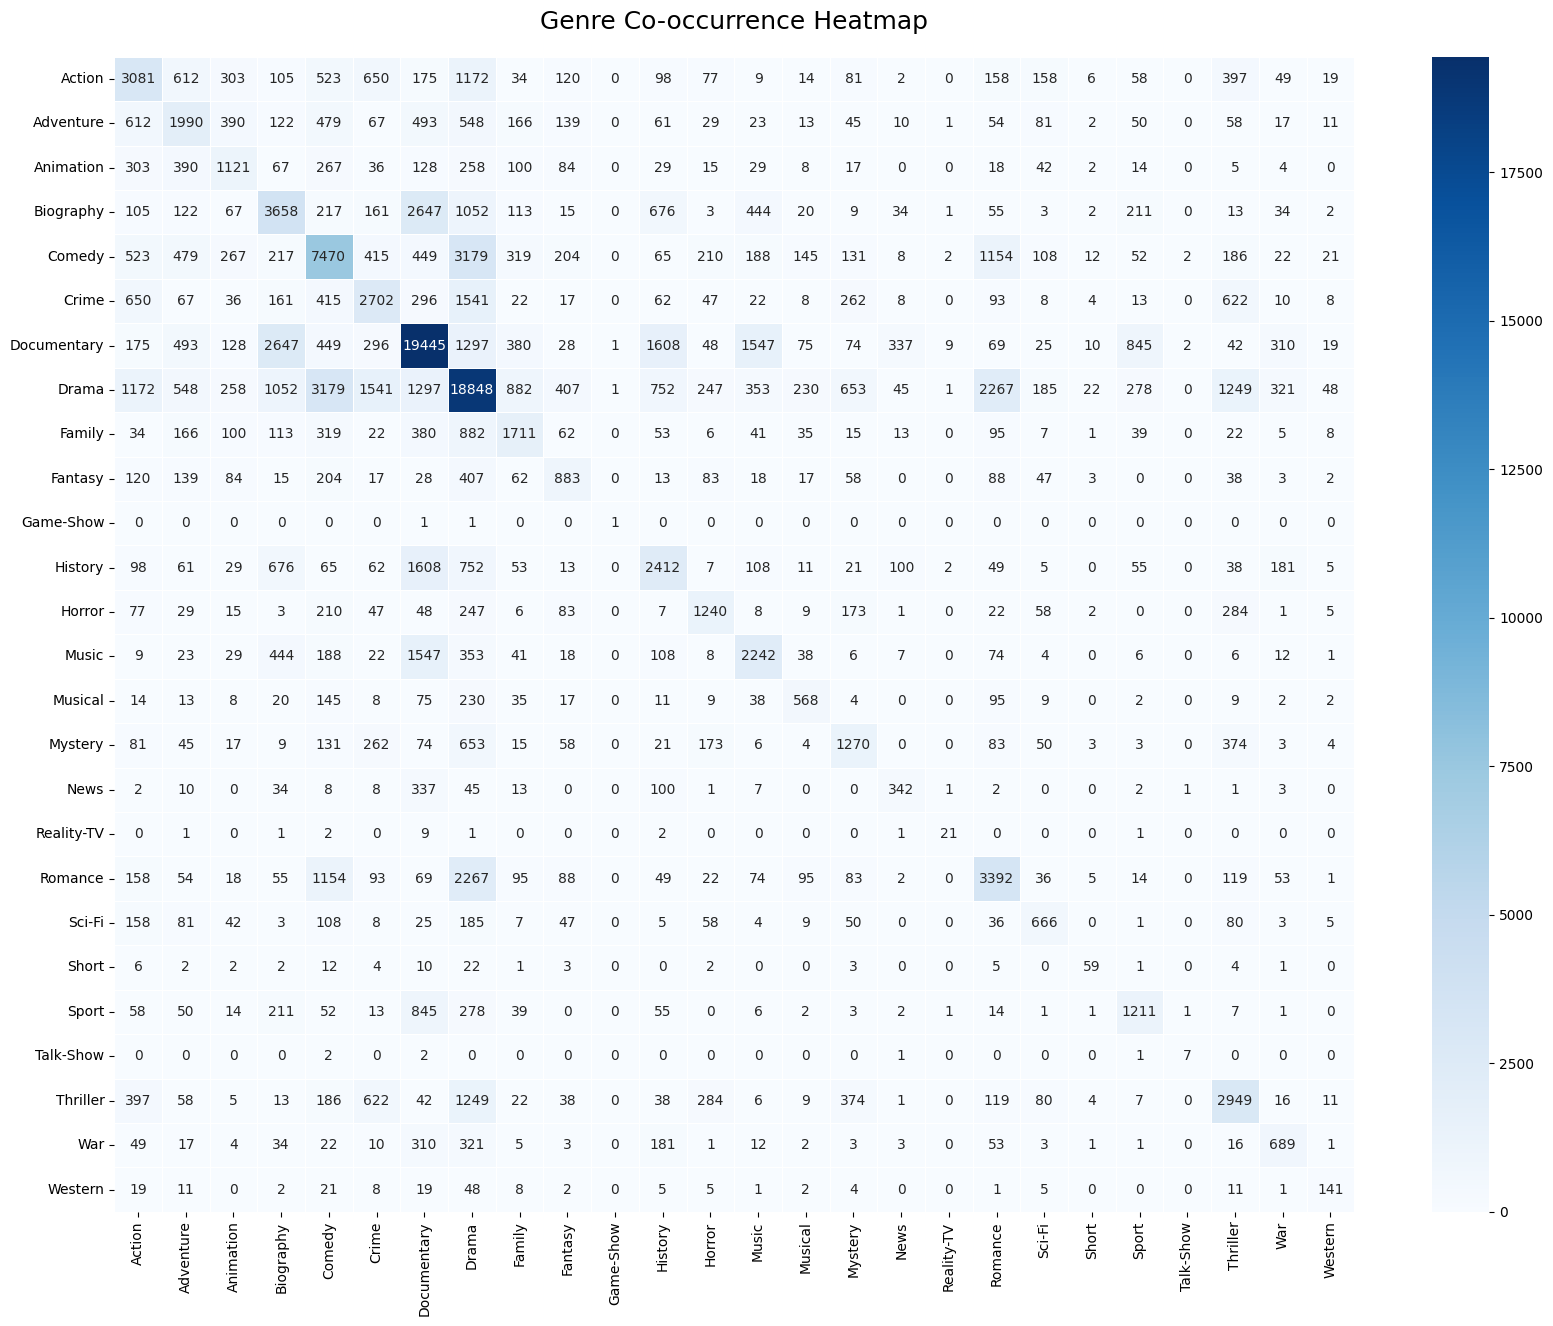

In [55]:
# Create co-occurrence matrix
# The diagonal values show how often a category appears individually
# The off-diagonal values show how often two categories appear together
co_occurrence = one_hot_genres.T.dot(one_hot_genres)

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5)

plt.title("Genre Co-occurrence Heatmap",
             size=18,
             color='black',
             pad=20)

plt.show()

Remove genres with few occurrences: "Game-Show", "Reality-TV", "Short", "Talk-Show"

In [57]:
# List of genres to eliminate
genres_to_remove = ["Game-Show", "Reality-TV", "Short", "Talk-Show"]

# Keep only rows where "genre" does not contain any of the unwanted genres
df = df[~df["genre"].str.contains("|".join(genres_to_remove), na=False)]

# Drop these genres from the one-hot encoded DataFrame (if already encoded)
one_hot_genres = one_hot_genres.drop(columns=genres_to_remove, errors="ignore")

In [58]:
df.shape

(46438, 14)

### **4.1 Remove "Documentary"**

**Documentary** is an ambiguous genre. A documentary poster can easily be mistaken for that of a regular movie.
We will delete all movies where “Documentary” is the only genre and remove the word “Documentary” from movies that have it as one of multiple genres.

In [60]:
# Check initial dataset size
print(f"Initial dataset size: {df.shape[0]}")

# Step 1: Remove movies where "Documentary" is the only genre
df = df[df["genre"] != "Documentary"]

# Step 2: Remove "Documentary" from genre lists where it appears with other genres
df["genre"] = df["genre"].apply(
    lambda g: ", ".join([genre.strip() for genre in g.split(",") if genre.strip().lower() != "documentary"])
)

# Check final dataset size
print(f"Final dataset size: {df.shape[0]}")

Initial dataset size: 46438
Final dataset size: 34493


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_80743/2836255213.py:4: SyntaxWarning: invalid escape sequence '\s'
  df['genre_list'] = df['genre'].str.split(',\s*')


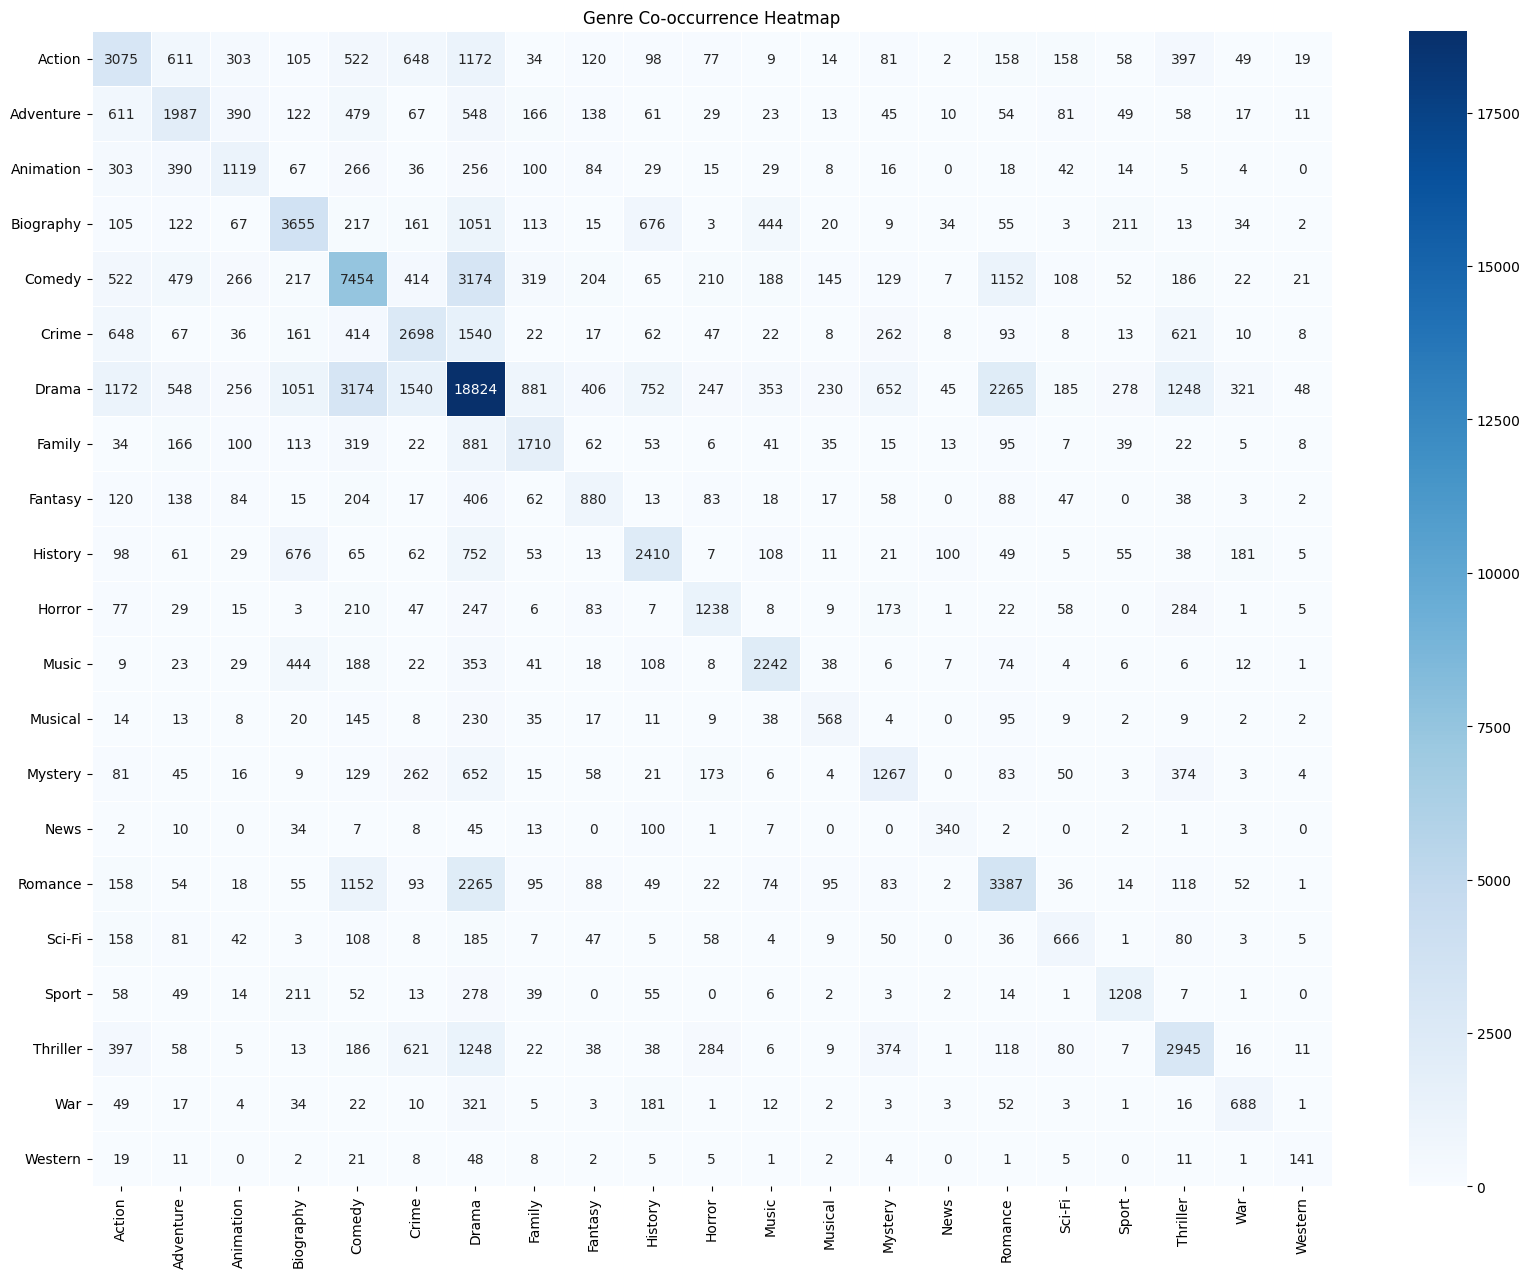

In [61]:
# Check co-occurences again

# Split the 'genre' column into list of genres
df['genre_list'] = df['genre'].str.split(',\s*')

# One-Hot Encoding the “genre” Feature
mlb = MultiLabelBinarizer()
one_hot_genres = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
co_occurrence = one_hot_genres.T.dot(one_hot_genres)

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", fmt=".0f", linewidths=0.5)

plt.title("Genre Co-occurrence Heatmap")
plt.show()

Text(0.5, 1.0, 'Distribution of Movie Genres by Count')

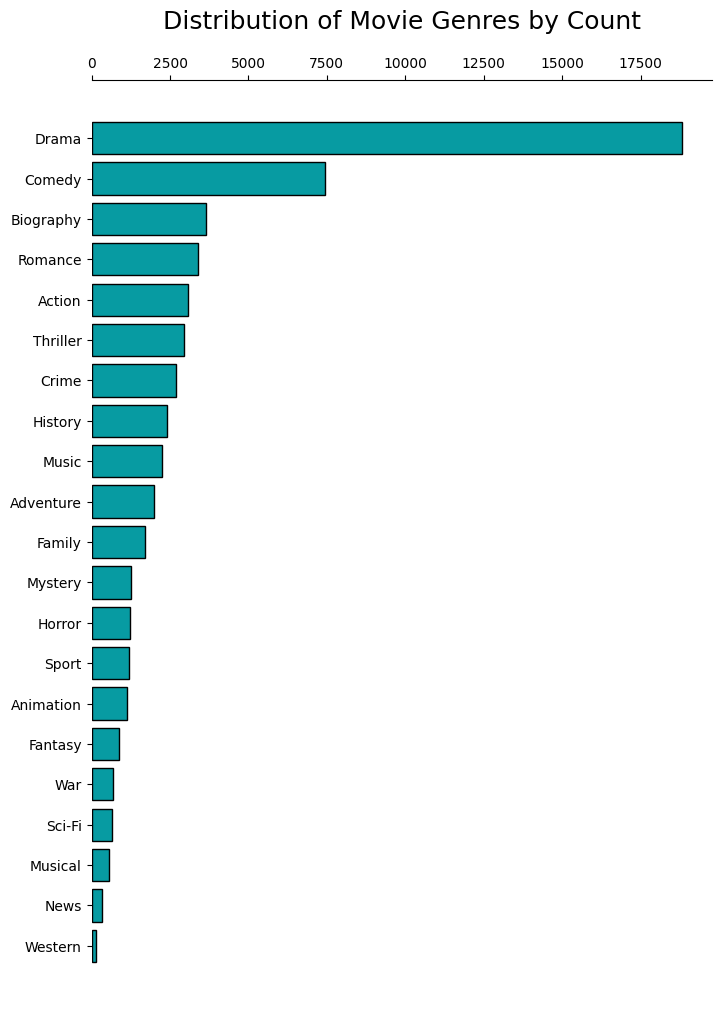

In [62]:
# Sort genres by count in descending order
genre_count = one_hot_genres.sum().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 12))
ax.barh(genre_count.index, genre_count.values, color='#079BA2', edgecolor='black')
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()

# Labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Distribution of Movie Genres by Count',
             size=18,
             color='black',
             pad=20)

In [63]:
df.to_csv("movie_df_clean.csv", index=False)

### **4. Download movie posters**

In [65]:
posters = df['poster'].to_list()

In [66]:
df.reset_index(inplace=True)


In [67]:
df.drop('index', axis=1, inplace=True)

In [68]:
# for i, url in enumerate(posters):
#     # print(url)
#     data = requests.get(url).content 
#     # print(df['tconst'][i])
#     # print(i)
#     f = open('Data/WithText/' + df['tconst'][i] + '.jpg','wb') 
#     f.write(data) 
#     f.close()

### **5. Removing non-poster images**

We observe that **real movie posters** typically have a **height-to-width (h/w) ratio of around 1.5.** As a first step, we create a histogram of poster shape ratios to understand their distribution.

In [71]:
# Empty list for storing poster shape ratios
ratios = []

# Iterate over each movie ID in the 'tconst' column of the DataFrame
for id in df['tconst']:
    try: 
        # Construct the image file path based on the movie ID
        image_path = 'Data/WithText/' + id + '.jpg'

        # Open the image file
        image = Image.open(image_path)

        # Convert the image into a NumPy array
        image_array = np.array(image)

        # Compute the shape ratio (height/width) of the image
        shape_ratio = image_array.shape[0] / image_array.shape[1]

        # Append the computed ratio to the list
        ratios.append(shape_ratio)

        # Add a "shape" column to the DataFrame
        df.loc[df["tconst"] == id, "shape"] = shape_ratio

    # Handle the case where the image file is missing
    except FileNotFoundError:
        # Remove the row corresponding to the missing poster from the DataFrame
        df = df[df["tconst"] != id]

    # Handle cases where the image file is corrupted or not a valid image
    except UnidentifiedImageError:
        # Remove the row corresponding to the invalid poster from the DataFrame
        df = df[df["tconst"] != id]

        # Delete the corrupted or unrecognized image file from the directory
        os.remove(image_path)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29265 entries, 0 to 34492
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tconst      29265 non-null  object 
 1   title       29265 non-null  object 
 2   year        29265 non-null  object 
 3   genre       29265 non-null  object 
 4   director    29265 non-null  object 
 5   actors      29265 non-null  object 
 6   plot        29265 non-null  object 
 7   country     29265 non-null  object 
 8   awards      29265 non-null  object 
 9   poster      29265 non-null  object 
 10  rating      29265 non-null  float64
 11  votes       29265 non-null  float64
 12  type        29265 non-null  object 
 13  genre_list  29265 non-null  object 
 14  shape       29265 non-null  float64
dtypes: float64(3), object(12)
memory usage: 3.6+ MB


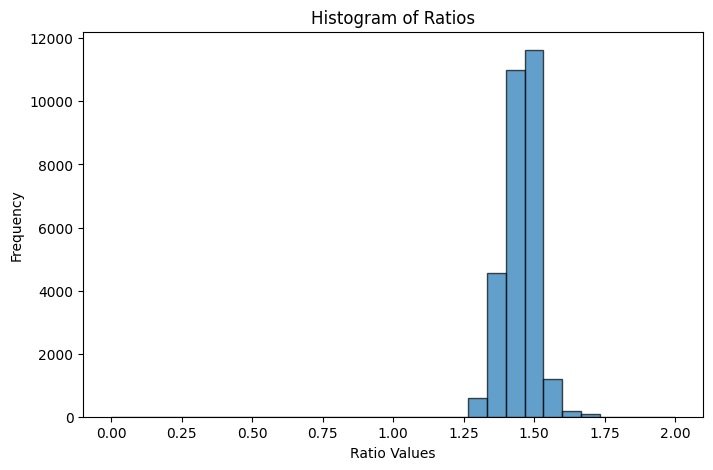

In [73]:
# Create a new figure with a specified size (width=8 inches, height=5 inches)
plt.figure(figsize=(8, 5))

# Plot a histogram of the 'ratios' list
# - bins=20: Divides the range into 20 bins for better granularity
# - range=(0, 2): Limits the x-axis values from 0 to 2
# - edgecolor='black': Adds black borders to bars for better visibility
# - alpha=0.7: Sets transparency level to make bars slightly see-through
plt.hist(ratios, bins=30, range=(0, 2), edgecolor='black', alpha=0.7)

# Add labels and title to the histogram
plt.xlabel("Ratio Values")  # Label for the x-axis
plt.ylabel("Frequency")      # Label for the y-axis
plt.title("Histogram of Ratios")  # Title of the plot

# Display the histogram
plt.show()

We delete all movies with a poster shape ratio **greater than 1.7** or **less than 1.3.**

In [75]:
# Filter rows where shape is within the range (1.3, 1.7)
movies_to_delete = df[(df["shape"] > 1.7) | (df["shape"] < 1.3)]

# Iterate over movies to delete
for movie_id in movies_to_delete["tconst"]:
    image_path = f'Data/WithText/{movie_id}.jpg'  # Construct file path
    
    # Check if the file exists before attempting to delete
    if os.path.exists(image_path):
        os.remove(image_path)  # Delete the file
    
# Remove the filtered rows from the DataFrame
df = df[(df["shape"] <= 1.7) & (df["shape"] >= 1.3)]

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29265 entries, 0 to 34492
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tconst      29265 non-null  object 
 1   title       29265 non-null  object 
 2   year        29265 non-null  object 
 3   genre       29265 non-null  object 
 4   director    29265 non-null  object 
 5   actors      29265 non-null  object 
 6   plot        29265 non-null  object 
 7   country     29265 non-null  object 
 8   awards      29265 non-null  object 
 9   poster      29265 non-null  object 
 10  rating      29265 non-null  float64
 11  votes       29265 non-null  float64
 12  type        29265 non-null  object 
 13  genre_list  29265 non-null  object 
 14  shape       29265 non-null  float64
dtypes: float64(3), object(12)
memory usage: 3.6+ MB


In [77]:
df.to_csv("movie_df_clean.csv", index=False)

In [78]:
df = pd.read_csv("movie_df_clean.csv")

In [79]:
df.head()

,tconst,title,year,genre,director,actors,plot,country,awards,poster,rating,votes,type,genre_list,shape
0,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,9.0,10.0,movie,['Horror'],1.403333
1,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,7.1,36.0,movie,['Drama'],1.396667
2,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,7.7,79.0,movie,"['Comedy', 'Sci-Fi']",1.480000
3,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,8.2,7.0,movie,['Thriller'],1.480000
4,tt10508276,Santo Domingo,2020,History,José Enrique Pintor,"Sebastian Kahuna, Víctor Daniel Gómez García, ...",The story of the foundation of the first city ...,Dominican Republic,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDYxZW...,7.9,12.0,movie,['History'],1.480000


In [140]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Define the start and end hex colors
start_color = "#E8F8F9"
end_color = "#00AFB9"

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list("cyan_to_orange", [start_color, end_color])

# Optional: register it globally (so you can use it by name later)
plt.colormaps.register(name="WhiteToOttanio", cmap=custom_cmap)

In [100]:
# Split the 'genre' column into list of genres
df['genre_list'] = df['genre'].str.split(',\s*')

# One-Hot Encoding the “genre” Feature
mlb = MultiLabelBinarizer()
one_hot_genres = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_)
co_occurrence = one_hot_genres.T.dot(one_hot_genres)


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dk/nwt6ddv12cd3hjtm1brdfz2m0000gn/T/ipykernel_80743/736374641.py:2: SyntaxWarning: invalid escape sequence '\s'
  df['genre_list'] = df['genre'].str.split(',\s*')


In [2]:
# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence, annot=True, cmap="WhiteToOttanio", fmt=".0f", linewidths=0.5)

plt.title("Genre Co-occurrence Heatmap")
plt.savefig('Plots/Genre Co-occurrence Heatmap.png', dpi=300, transparent=True)
plt.show()

NameError: name 'plt' is not defined

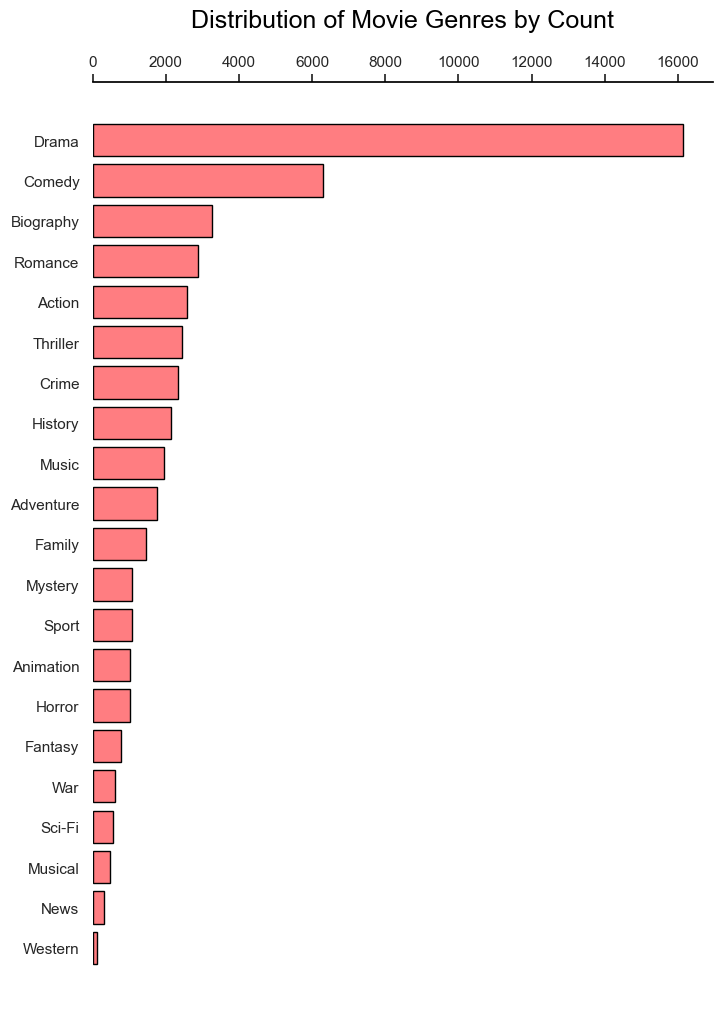

In [183]:
# Sort genres by count in descending order
genre_count = one_hot_genres.sum().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 12))
ax.barh(genre_count.index, genre_count.values, color='#FF7D81', edgecolor='black')
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()

# Labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Distribution of Movie Genres by Count',
             size=18,
             color='black',
             pad=20)
plt.savefig('Plots/Distribution of Movie Genres by Count.png', dpi=300, transparent=True)

### **6. Movies single-genre selection**

In [81]:
# Set your OpenAI API key
client = openai.OpenAI(api_key=openai_api_key) 

# List of all unique genres
all_genres = [
    "Drama", "Comedy", "Thriller", "Romance", "Animation", "Music",
    "History", "Action", "Horror", "Adventure", "Biography", "Sci-Fi", "Crime",
    "Musical", "Family", "Sport", "Fantasy", "Mystery", "War", "Western", "News"
]


In [82]:
# Function to truncate movie plots (to prevent excessive tokens)
def truncate_text(text, max_chars=500):
    """Trims text to avoid exceeding token limits."""
    return text[:max_chars] if isinstance(text, str) else ""

# Function to generate embeddings with batch processing & token control
def get_openai_embeddings(texts, batch_size=5):
    """Splits texts into batches and gets embeddings safely."""
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Get a small batch

        # Truncate all texts to ensure they are not too long
        batch = [truncate_text(text) for text in batch]

        try:
            response = client.embeddings.create(
                input=batch,
                model="text-embedding-3-large"
            )
            all_embeddings.extend([np.array(embedding.embedding) for embedding in response.data])
        except openai.APITimeoutError:
            print(f"Timeout error on batch {i}-{i + batch_size}. Retrying with batch size 1.")
            return get_openai_embeddings(texts, batch_size=1)  # Retry with batch size 1
        except openai.BadRequestError as e:
            print(f"Error: {e} on batch {i}-{i + batch_size}. Skipping problematic batch.")
            continue  # Skip batch if still too long

    return all_embeddings


In [83]:
# Step 1: Compute embeddings for all unique genres (Only once)
genre_embeddings = {genre: emb for genre, emb in zip(all_genres, get_openai_embeddings(all_genres))}

In [146]:
# Step 2: Generate embeddings for all movie plots in batches
df["plot"] = df["plot"].apply(truncate_text)  # Apply truncation
df["plot_embedding"] = get_openai_embeddings(df["plot"].tolist(), batch_size=5)

In [150]:
# Step 3: Function to select the most relevant genre
def select_most_relevant_genre(genre_list, plot_embedding):
    if len(genre_list) == 1:
        return genre_list[0]  # If only one genre, return it

    # Retrieve precomputed genre embeddings for the available genres
    valid_genre_embeddings = np.array([genre_embeddings[genre] for genre in genre_list])

    # Compute cosine similarity between plot embedding and genre embeddings
    similarities = cosine_similarity(plot_embedding.reshape(1, -1), valid_genre_embeddings)[0]

    # Select the genre with the highest similarity
    return genre_list[np.argmax(similarities)]

In [151]:
# Ensure genre_list is stored as a list
df["genre_list"] = df["genre_list"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Apply function in a vectorized manner
df["most_relevant_genre"] = [
    select_most_relevant_genre(genre_list, plot_emb)
    for genre_list, plot_emb in zip(df["genre_list"], df["plot_embedding"])
]

# Drop unnecessary columns
df.drop(columns=["genre_list", "plot_embedding"], inplace=True)

In [152]:
df.to_csv("movie_df_clean.csv", index=False)

In [153]:
df["most_relevant_genre"]

0          Horror
1           Drama
2          Sci-Fi
3        Thriller
4         History
           ...   
29260     History
29261       Drama
29262     History
29263      Sci-Fi
29264      Family
Name: most_relevant_genre, Length: 29265, dtype: object

In [154]:
df["most_relevant_genre"].value_counts().sort_values()

most_relevant_genre
Western         71
News           151
Fantasy        273
Musical        278
War            360
Animation      413
Sci-Fi         457
Family         549
Mystery        566
Action         628
Sport          685
Horror         796
Crime         1011
History       1037
Thriller      1171
Adventure     1293
Music         1469
Romance       1851
Biography     2334
Comedy        3069
Drama        10803
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Movie Genres by Count')

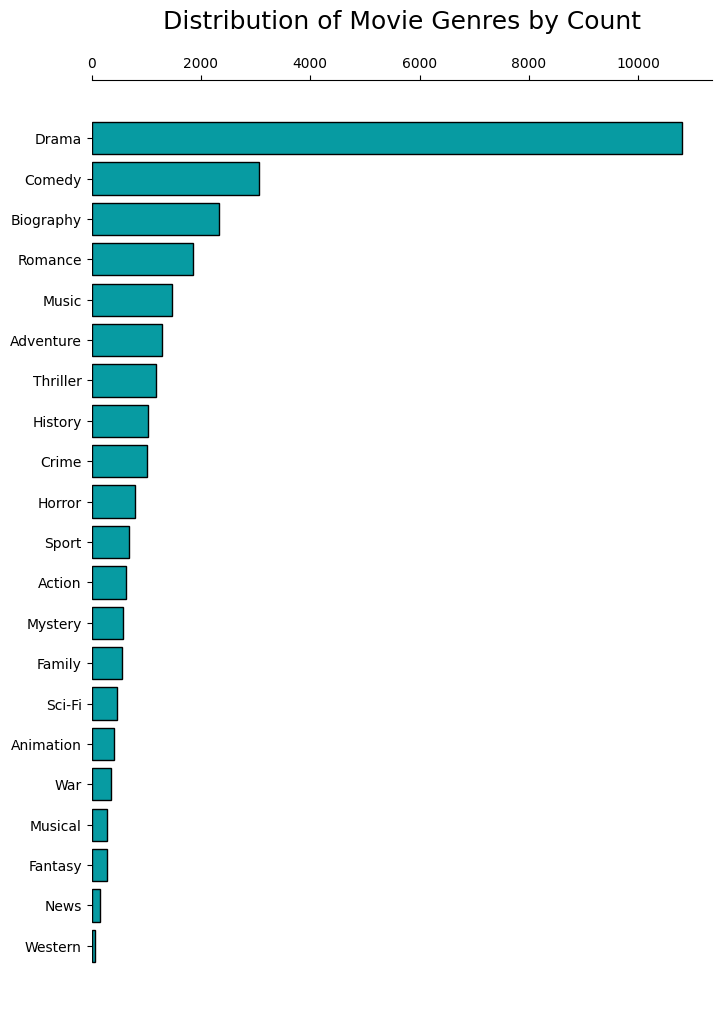

In [155]:
# Sort genres by count in descending order
genre_count = df["most_relevant_genre"].value_counts().sort_values(ascending=True)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 12))
ax.barh(genre_count.index, genre_count.values, color='#079BA2', edgecolor='black')
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()

# Labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Distribution of Movie Genres by Count',
             size=18,
             color='black',
             pad=20)

### **6.1. Semantic Similarity & Hierarchical Merging**

This implementation will:
	1.	Use your precomputed genre embeddings.
	2.	Compute pairwise cosine similarity between genres.
	3.	Perform hierarchical clustering to group genres.
	4.	Visualize clusters using a dendrogram.
	5.	Apply Agglomerative Clustering to merge into 5-7 genre categories.

In [157]:
# Compute genre embeddings again, this time not considering the most frequent genre: Drama

reduced_genres = [
    "Comedy", "Thriller", "Romance", "Animation", "Music",
    "History", "Action", "Horror", "Adventure", "Biography", "Sci-Fi", "Crime",
    "Musical", "Family", "Sport", "Fantasy", "Mystery", "War", "Western", "News"
]

genre_embeddings = {genre: emb for genre, emb in zip(reduced_genres, get_openai_embeddings(reduced_genres))}

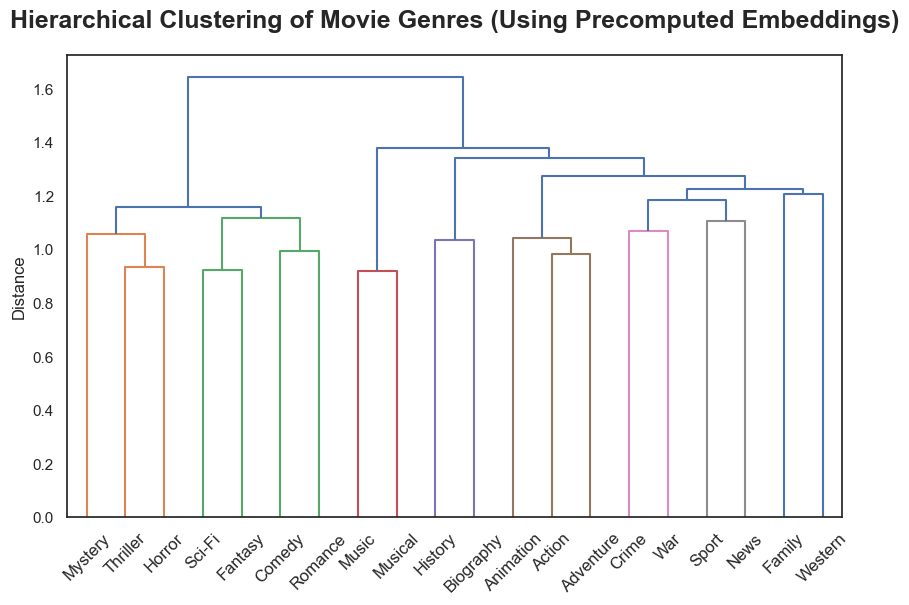

Cluster 2: ['Comedy', 'Thriller', 'Romance', 'Horror', 'Sci-Fi', 'Fantasy', 'Mystery']
Cluster 1: ['Animation', 'Action', 'Adventure', 'Crime', 'Sport', 'War', 'News']
Cluster 6: ['Music', 'Musical']
Cluster 3: ['History', 'Biography']
Cluster 4: ['Family']
Cluster 5: ['Western']


In [187]:
# Step 1: Load precomputed genre embeddings
# Assuming you have: genre_embeddings = {genre: emb}
all_genres = list(genre_embeddings.keys())  # Extract genre names
embedding_matrix = np.array(list(genre_embeddings.values()))  # Convert embeddings to NumPy array

# Step 2: Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embedding_matrix)

# Step 3: Perform hierarchical clustering
linked = sch.linkage(embedding_matrix, method="ward")

# Step 4: Plot the dendrogram
plt.figure(figsize=(10, 6))
sch.dendrogram(linked, labels=all_genres, orientation="top", leaf_rotation=45)
plt.title("Hierarchical Clustering of Movie Genres (Using Precomputed Embeddings)", pad=20, weight="bold", size=18)
plt.ylabel("Distance")
plt.savefig('Plots/Hierarchical Clustering of Movie Genres.png', dpi=300, transparent=True)
plt.show()

# Step 5: Apply Agglomerative Clustering with updated argument
num_clusters = 6  # Adjust based on desired number of categories
cluster_model = AgglomerativeClustering(n_clusters=num_clusters, metric="cosine", linkage="average")
genre_labels = cluster_model.fit_predict(embedding_matrix)

# Step 6: Group genres based on clusters
genre_clusters = {}
for genre, cluster in zip(all_genres, genre_labels):
    genre_clusters.setdefault(cluster, []).append(genre)

# Step 7: Print final genre groupings
for cluster_id, grouped_genres in genre_clusters.items():
    print(f"Cluster {cluster_id + 1}: {grouped_genres}")

proposed clusters, based on the clustering:

Cluster 1: ['Thriller', 'Horror', 'Mystery']  
Cluster 2: ['Sci-Fi', 'Fantasy']  
Cluster 3: ['Comedy', 'Romance']  
Cluster 4: ['Music', 'Musical']  
Cluster 5: ['History', 'Biography']  
Cluster 6: ['Animation', 'Action', 'Adventure']  
Cluster 7: ['Crime', 'Sport']  
Cluster 8: ['Sport', 'War']  
Cluster 9: ['Family', 'Western']  


In [169]:
# Step 1: Define the genre mapping based on clustering results
genre_mapping = {
    "Drama": "Drama",
    
    "Thriller": "Suspense",
    "Horror": "Suspense",
    "Mystery": "Suspense",
    
    "Sci-Fi": "Sci-Fi/Fantasy",
    "Fantasy": "Sci-Fi/Fantasy",
    
    "Comedy": "Comedy/Romance",
    "Romance": "Comedy/Romance",

    "Animation": "Action/Adventure",
    "Action": "Action/Adventure",
    "Adventure": "Action/Adventure",

    "Music": "Music/Musical",
    "Musical": "Music/Musical",

    "History": "Historical/Biography",
    "Biography": "Historical/Biography",

    "Crime": "War/Crime",
    "War": "War/Crime",
    
    "Sport": "Sport/News",
    "News": "Sport/News",

    "Family": "Western/Family",
    "Western": "Western/Family"
}

# Step 3: Apply the mapping to create a new column with reduced genres
df["reduced_genre"] = df["most_relevant_genre"].map(genre_mapping)

In [161]:
df = pd.read_csv("movie_df_clean.csv")

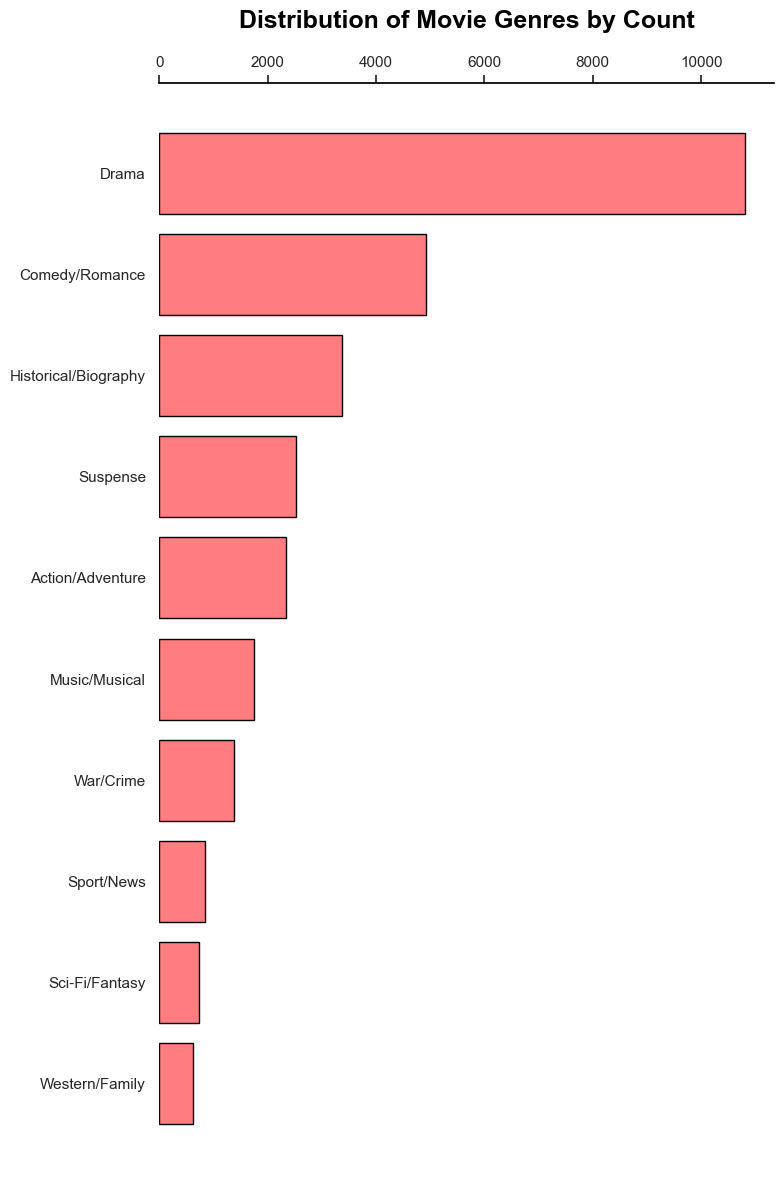

In [181]:
# Sort genres by count in descending order
genre_count = df["reduced_genre"].value_counts().sort_values(ascending=True)

# Create a horizontal bar chart
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

fig, ax = plt.subplots(figsize=(8, 12))
ax.barh(genre_count.index, genre_count.values, color='#FF7D81', edgecolor='black')

ax.spines[['bottom', 'right', 'left']].set_visible(False)
ax.spines['top'].set_color('black')

ax.xaxis.tick_top()

# Labels and title
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Distribution of Movie Genres by Count',
             size=18,
             color='black', 
             weight='bold',
             pad=20)

plt.tight_layout()
plt.savefig("Plots/Distribution of Reduced Movie Genres by Count.png", dpi=300, transparent=True)
plt.show()

In [171]:
df

,tconst,title,year,genre,director,actors,plot,country,awards,poster,rating,votes,type,shape,most_relevant_genre,reduced_genre
0,tt3608918,Azzurrina,2023,Horror,Giacomo Franciosa,"Tatiana Luter, Paolo Stella, Gianfranco Terrin",The tale of Guendalina was passed down verball...,Italy,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BOWQ5MG...,9.0,10.0,movie,1.403333,Horror,Suspense
1,tt28378602,Zena s gumenim rukavicama,2023,Drama,Mario Sulina,"Areta Curkovic, Sandra Loncaric, Miro Cabraja",The film was inspired by the great strike of e...,Croatia,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BODE4NG...,7.1,36.0,movie,1.396667,Drama,Drama
2,tt27129223,Fast Shark II: Faster Shark,2023,"Comedy, Sci-Fi",Chloe Pelletier,"Grace Barrington, John Bradshaw, Josefa Calero",A fast shark that has grown even faster contin...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BYWY0NT...,7.7,79.0,movie,1.480000,Sci-Fi,Sci-Fi/Fantasy
3,tt15173938,Shooting Guard,2022,Thriller,Luke Ostermiller,"Agapi Petra, Myles Juniel, Exzinia Scott",In an effort to save his mom from being evicte...,United States,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BN2FjZD...,8.2,7.0,movie,1.480000,Thriller,Suspense
4,tt10508276,Santo Domingo,2020,History,José Enrique Pintor,"Sebastian Kahuna, Víctor Daniel Gómez García, ...",The story of the foundation of the first city ...,Dominican Republic,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BNDYxZW...,7.9,12.0,movie,1.480000,History,Historical/Biography
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29260,tt0484037,Gente mala del norte,2011,"Drama, History",Patricio Riquelme,"Luis Alarcón, Juan Falcón, Giovanni Falcchetti","In the Strait of Magellan, on 1923, an Irish p...",Chile,1 nomination,https://m.media-amazon.com/images/M/MV5BYWM2ZW...,8.8,8.0,movie,1.450000,History,Historical/Biography
29261,tt2611518,Lights Out,2013,Drama,Adam Shaw,"Kelly Ann Bourne, Andy Demetrio, Joe Elias, Ha...","When Mark Daniels, a 33 year old born and bred...",USA,0 awards and 0 nominees,https://m.media-amazon.com/images/M/MV5BMTg0OD...,8.4,29.0,movie,1.366667,Drama,Drama
29262,tt1777034,United,2011,"Drama, History, Sport",James Strong,"Dean Andrews, Kate Ashfield, Natalie Burt",United is based on the true story of Mancheste...,United Kingdom,3 nominations total,https://m.media-amazon.com/images/M/MV5BYWQ3M2...,7.3,13410.0,movie,1.413333,History,Historical/Biography
29263,tt1620487,Invertebrate,2011,Sci-Fi,James McAleer,Unknown,Through the course of a day in a city inhabite...,UK,2 wins.,https://m.media-amazon.com/images/M/MV5BMTQ1Mz...,7.5,25.0,movie,1.480000,Sci-Fi,Sci-Fi/Fantasy


In [191]:
df.to_csv("movie_df_clean.csv", index=False)